In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
import math
plt.style.use('ggplot')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words[:10])

2025-09-20 14:39:18.207557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


In [2]:
df = pd.read_csv('IMDB_Dataset.csv')

In [3]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

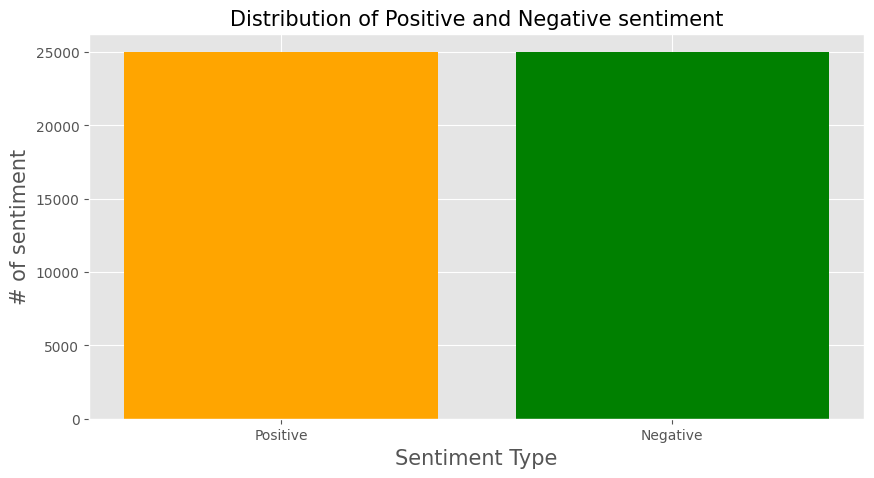

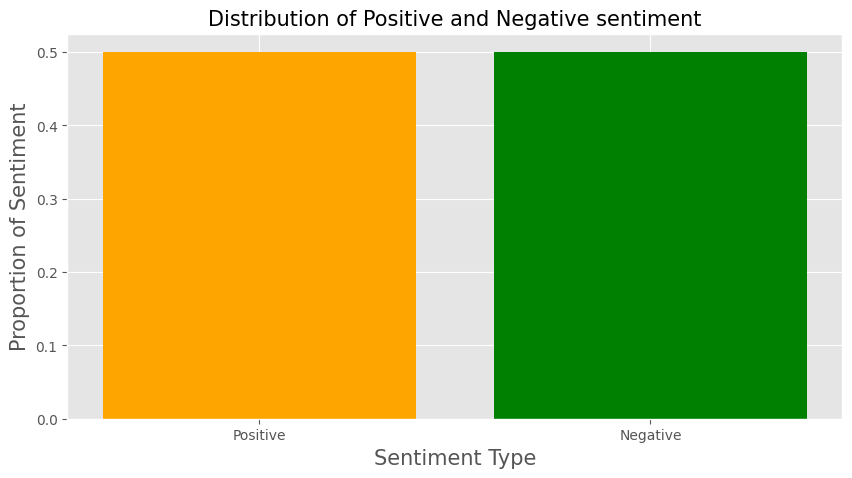

In [4]:
# Comptes
positive_count = sum(df["sentiment"] == "positive")
negative_count = sum(df["sentiment"] == "negative")
total_len = len(df["sentiment"])

# Plot nombre absolu
plt.figure(figsize=(10, 5))
plt.bar('Positive', positive_count, color='orange')
plt.bar('Negative', negative_count, color='green')
plt.title('Distribution of Positive and Negative sentiment', size=15)
plt.xlabel('Sentiment Type', size=15)
plt.ylabel('# of sentiment', size=15)
plt.show()

# Plot proportion
plt.figure(figsize=(10, 5))
plt.bar('Positive', positive_count / total_len, color='orange')
plt.bar('Negative', negative_count / total_len, color='green')
plt.title('Distribution of Positive and Negative sentiment', size=15)
plt.xlabel('Sentiment Type', size=15)
plt.ylabel('Proportion of Sentiment', size=15)
plt.show()

In [5]:
features = df['review']
targets = df['sentiment']

In [6]:
#List of stop words
stop_words = set(stopwords.words('english'))

#Delete stopwords
features.apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized



X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

X_train = normalize(X_train)
X_test = normalize(X_test)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/antonindoat/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
